# Estimating parameters in an ODE system using SciPy

Estimating parameters in the context of differential equations a frequent challenge. In the following we implement a simple ODE system (the Lotka-Voltera model for a prey-predator population) and use SciPy to, both, solve it and estimate its parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
%load_ext watermark
%watermark -p numpy,matplotlib,scipy

numpy 1.17.2
matplotlib 3.1.1
scipy 1.1.0


The Lotka-Voltera equations read
\begin{align}
 dy_1/dt &= p_1 y_1 - p_2 y_1 y_2, \\
 dy_2/dt &= p_3 y_1 y_2 - p_4 y_2
\end{align}
where $y_1(t)$ is the number of prey, $y_2(t)$ the number of predators and $p_i$ are positive real parameters.

In [2]:
def lotka_voltera(t, y, p):
    return [
        p[0] * y[0] - p[1] * y[0] * y[1],
        p[2] * y[0] * y[1] - p[3] * y[1]
    ]

We generate some experimental data.

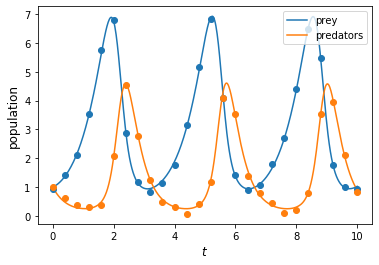

In [3]:
p_true = [1.5, 1, 1, 3]

sol = solve_ivp(
    fun=lambda t, y: lotka_voltera(t, y, p_true),
    y0=[1, 1],
    t_span=(0, 10),
    t_eval=np.linspace(0, 10, 501)
)

# experimental observations every 0.4 time units
t_obs = sol.t[::20]
y_obs = sol.y[:, ::20].copy()
y_obs += 0.1 * np.random.randn(*y_obs.shape)  # iid additive Gaussian noise

plt.plot(sol.t, sol.y.T)
plt.plot(t_obs, y_obs[0], 'C0 o')
plt.plot(t_obs, y_obs[1], 'C1 o')
plt.legend(['prey', 'predators'])
plt.xlabel('$t$')
plt.ylabel('population');

We set up a squared loss by computing the populations for given parameters p and comparing against the experimental data.

In [4]:
def loss(p):
    sol = solve_ivp(
        fun=lambda t, y: lotka_voltera(t, y, p),
        y0=[1, 1],
        t_span=(0, 10),
        t_eval=t_obs
    )
    if sol.success:
        return np.sum((sol.y - y_obs) ** 2)
    else:
        print('solve_ivp failed for p =', p)
        return np.inf

loss(p_true)

0.44834743428880663

Finally, we minimize this loss using L-BFGS-B. The gradients need to approximated via finite differences as the ODE solver does not return us gradients which could be passed to the optimizer.

In [5]:
res = minimize(
    loss, 
    x0=[1.45, 1, 1, 2.9], # initial guess for p
    bounds=[(0.1, 5), (0.1, 5), (0.1, 5), (0.1, 5)])
res

      fun: 0.7660100371064344
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 20.16690268,  13.75970575,  94.22142524, -44.90102038])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 965
      nit: 46
   status: 0
  success: True
        x: array([1.58149297, 1.06914332, 0.92980058, 2.77020297])

Interestingly, even when starting close to the true parameters, the optimum found is clearly worse than the true parameters. Also, the optimization fails for certain starting points, as was the case here.

Let's look at the partial dependence of the loss with respect to the individual parameters, keeping the others fixed at their true value. Apart from local minima w.r.t. $p_1$, the partial dependency looks rather benign.

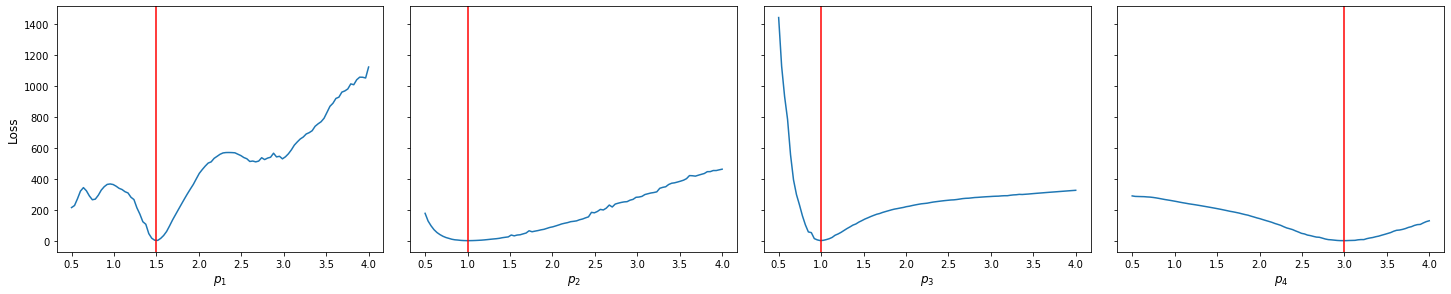

In [6]:
def loss_pi(pi, i=0):
    p = p_true.copy()
    p[i] = pi
    return loss(p)

fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey=True)
fig.tight_layout()
P = np.linspace(0.5, 4, 101)
for i, ax in enumerate(axs):
    L = [loss_pi(p, i=i) for p in P]
    ax.plot(P, L)
    ax.axvline(p_true[i], color='red')
    ax.set_xlabel(f'$p_{i+1}$')
axs[0].set_ylabel('Loss');

This is a bit disappointing. As alternatives to scipy we could try [pyomo](http://www.pyomo.org/), [GEKKO](https://gekko.readthedocs.io), or even TensorFlow which has an [ODE solver returning gradients](https://www.tensorflow.org/probability/api_docs/python/tfp/math/ode/Solver).